In [226]:
# conda activate chronocell

import os
import sys
import numpy as np
import pandas as pd
import anndata as ad

sys.path.append("/mnt/lareaulab/reliscu/programs/FGP_2024")

import Chronocell
print(Chronocell.__version__)

from Chronocell.inference import Trajectory
from Chronocell.mixtures import PoissonMixtureSS
from Chronocell.utils import *
from Chronocell.plotting import *
from Chronocell.models.two_species_ss import get_Y

2024.10


In [227]:
# Ref: https://www.nature.com/articles/nature10098#Fig2

In [228]:
variable_param = 'deg_rate'

In [229]:
# Splicing rate
beta_mu = 2
beta_sd = 0.5

# Transcription rate
alpha_mu = np.log(2)
alpha_sd = 1

# Translation rate
transl_rate_mu = np.log(100)
transl_rate_sd = 1

# mRNA degradation rate
rna_median_half_life = 9
gamma_rate = np.log(2) / rna_median_half_life
gamma_mu = np.log(gamma_rate) # Median of lognormal
gamma_sd = 0.5

# Protein degradation rate
protein_median_half_life = 46
deg_rate = np.log(2) / protein_median_half_life
deg_rate_mu = np.log(deg_rate) # Median of lognormal
deg_rate_sd = 1.5
# Simulate data

n = 1000 # No. cells per lineage
p = 100 # No. genes
m = 101 # No. time steps

topo = np.array([0, 1, 2, 3])
tau = (0, 1, 4, 12)
n_states = len(set(topo.flatten()))

# np.random.seed(0)

# Make all parameters constant except variable_param:

theta = np.zeros((p, n_states + 2))
phi = np.zeros((p, 2))
theta[:,:n_states] = np.tile(np.random.lognormal(alpha_mu, alpha_sd, size=(1, n_states)), (p, 1))
theta[:,-2] = np.random.lognormal(beta_mu, beta_sd) 
theta[:,-1] = np.random.lognormal(gamma_mu, gamma_sd)
theta[:,0] /= theta[:, -2]
phi[:,0] = np.random.lognormal(transl_rate_mu, transl_rate_sd) 
phi[:,-1] = np.random.lognormal(deg_rate_mu, deg_rate_sd)

if variable_param == "alpha":
    theta[:,:n_states] = np.random.lognormal(alpha_mu, alpha_sd, size=(p, n_states))
elif variable_param == "beta":
    theta[:,-2] = np.random.lognormal(beta_mu, beta_sd, size=p)
elif variable_param == "gamma":
    theta[:,-1] = np.random.lognormal(gamma_mu, gamma_sd, size=p)
elif variable_param == "transl_rate":
    phi[:,0] = np.random.lognormal(transl_rate_mu, transl_rate_sd, size=p)
else: # variable_param == "deg_rate"
    phi[:,-1] = np.random.lognormal(deg_rate_mu, deg_rate_sd, size=p)
    
# Simulate RNA counts

Y = np.zeros((n, p, 2))
t = np.sort(np.random.uniform(tau[0], tau[-1], size=n))
Y = get_Y(theta, t, tau) # Cells x genes x RNA species

# Simulate protein counts

y0 = Y[0, :, 1] # Steady-state spliced RNA levels (RNA levels at state 0 at t0
p0 = phi[:,0] * y0
# Protein production paramters:
transl_rate = phi[:,0].T
deg_rate = phi[:,-1].reshape((1, -1))
P = np.zeros((n, p))
t_l = t.reshape((-1, 1)) # Time points/cells in lineage l     
y_l = Y[:, :, 1] # Counts from cells in lineage l
t_diff = t_l - t_l.T 
# t_diff: rows = target time, columns = past times, e.g. t_diff[m, i] = time difference between t_m and t_i 
t_diff[t_diff < 0] = 0 
# Time contributions can't be negative
decay_matrix = np.exp(-t_diff[:, :, None] * deg_rate) 
# E.g. decay_matrix[m, i, p] = decay factor for protein abundance at t_m from RNA available at t_i (for gene p)
p_l = p0 * np.exp(-deg_rate * t_l) 
# Pre-existing protein that has not yet degraded
protein_contrib = np.einsum('mip, ip -> mp', decay_matrix, y_l) # Integrate RNA counts still surviving up to each time point
p_l += transl_rate * protein_contrib # Newly synthesized protein
P = p_l

data = pd.DataFrame(columns=['Cor', 'alpha', 'beta', 'gamma', 'transl_rate', 'deg_rate'])

for i in range(p):
    cor = np.corrcoef(Y[:, i, 1], P[:, i])[0, 1] # Correlation between RNA and protein abundance for gene i
    alpha_mean = np.mean(theta[i, :n_states]) # Mean transcription rate
    beta = theta[i, -2] # Splicing rate 
    gamma = theta[i, -1] # RNA degradation rate
    transl_rate = phi[i, 0] # Translation rate
    deg_rate = phi[i, -1] # Protein degradation rate
    data.loc[len(data)] = [cor, alpha_mean, beta, gamma, transl_rate, deg_rate]

# values = data[vars].iloc[0]
# values[mask] = np.nan
# var_vs_cor = np.corrcoef(data[variable_param], data['Cor'])[0, 1]
# datout.loc[len(datout)] = [variable_param, var_vs_cor] + list(values)

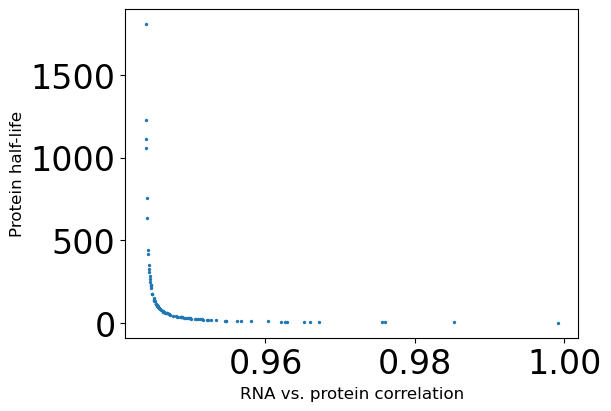

In [230]:
plt.figure(figsize=(6, 4))
plt.scatter(data['Cor'], np.log(2) / data['deg_rate'], s=2);
plt.xlabel('RNA vs. protein correlation', fontsize=12);
plt.ylabel('Protein half-life', fontsize=12);
# plt.xticks(fontsize=10);
# plt.yticks(fontsize=10);

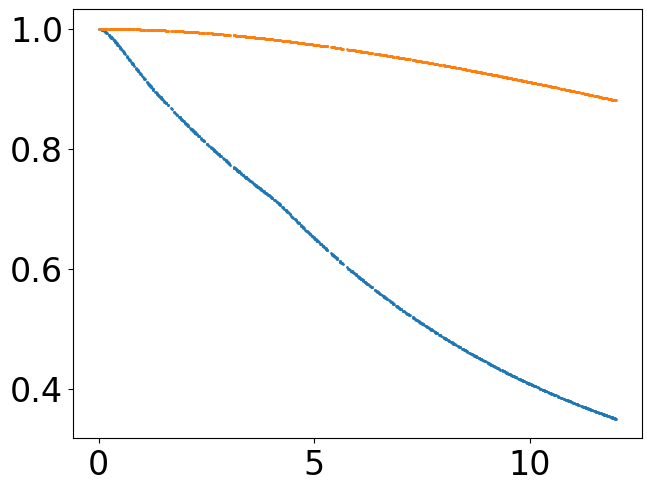

In [231]:
i = 1
y_i = Y[:, i, 1]/max(Y[:, i, 1])
p_i = P[:, i]/max(P[:, i])
plt.scatter(t, y_i, s=1)
plt.scatter(t, p_i, s=1)

In [235]:
data

,Cor,alpha,beta,gamma,transl_rate,deg_rate
0,0.946712,2.256348,5.017154,0.141387,213.959534,0.011726
1,0.948187,2.256348,5.017154,0.141387,213.959534,0.018123
2,0.945543,2.256348,5.017154,0.141387,213.959534,0.006764
3,0.947176,2.256348,5.017154,0.141387,213.959534,0.013723
4,0.951235,2.256348,5.017154,0.141387,213.959534,0.031870
...,...,...,...,...,...,...
95,0.945541,2.256348,5.017154,0.141387,213.959534,0.006756
96,0.949901,2.256348,5.017154,0.141387,213.959534,0.025764
97,0.946430,2.256348,5.017154,0.141387,213.959534,0.010520
98,0.985265,2.256348,5.017154,0.141387,213.959534,0.299193
